In [336]:
import pandas as pd
import numpy as np
import re
import random
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1, recall, accuracy
import gensim
from gensim.models import FastText


import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
DEVICE = torch.device('cuda') if torch.cuda.is_available()\
                              else torch.device('cpu')
DEVICE

device(type='cuda')

In [11]:
! ls ../input

fake-and-real-news-dataset


In [30]:
df = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv').drop_duplicates().reset_index(drop=True)

In [31]:
df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23473,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23474,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23475,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23476,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


# Данные
## First look
Тут у нас сильный дисбаланс классов, при таком классификатор обучать себе дороже, но мы далаем

<AxesSubplot:>

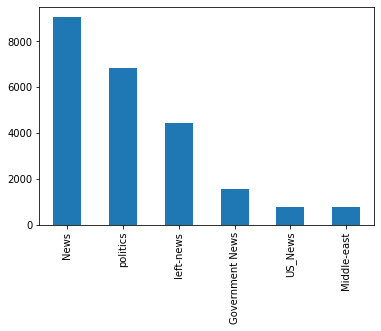

In [32]:
df['subject'].value_counts().plot.bar()

In [33]:
def preprocess(text):
    text = text.lower()
    text = word_tokenize(text)
    return text

In [36]:
df['clean_text'] = df['text'].progress_apply(preprocess)

100%|██████████| 23478/23478 [01:54<00:00, 205.88it/s]


In [37]:
df['category'] = df['subject'].astype('category').cat.codes

In [38]:
df

,title,text,subject,date,clean_text,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am...",2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme...",2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc...",2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ...",2
...,...,...,...,...,...,...
23473,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016","[21st, century, wire, says, as, 21wire, report...",1
23474,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016","[21st, century, wire, says, it, s, a, familiar...",1
23475,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016","[patrick, henningsen, 21st, century, wireremem...",1
23476,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016","[21st, century, wire, says, al, jazeera, ameri...",1


In [79]:
data = shuffle(df[['clean_text', 'category']])
train_data, val_data = train_test_split(data, test_size=0.2)

In [43]:
vocab = Counter()
for line in tqdm(data['clean_text']):
    vocab.update(line)

100%|██████████| 23478/23478 [00:01<00:00, 14923.59it/s]


In [106]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 59638


In [107]:
word2id = {'UNK':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

В статье берут максимальную длину предложения, но у меня не влезает в гпу по памяти, огрраничимся таким

In [47]:
MAX_LEN = 500

Эмбеддинги из статьи

In [48]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-22 12:26:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.105.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.105.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.2MB/s    in 34s     

2021-12-22 12:26:40 (45.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [50]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [72]:
weights = np.zeros((len(word2id), 300))

unknown = 0
for word, i in word2id.items():
    try:
        weights[i] = w2v[word]
    except KeyError:
        unknown += 1
        # из статьи: initialize the word vector for the unknown words from the uniform distribution [-0.25, 0.25]
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

weights = torch.FloatTensor(weights)

## Датасет

In [120]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.target = dataset['category'].values
        
        self.length = dataset.shape[0]
        self.word2id = word2id
        self.device = DEVICE

    def __len__(self):
        return self.length
    
    def __getitem__(self, index): 
        tokens = self.dataset[index] 
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id else self.word2id['UNK'] for token in tokens][:MAX_LEN])

        y = [self.target[index]]
        return ids, y
    
    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        padded_ids = torch.LongTensor(torch.stack([F.pad(idx, (1, MAX_LEN - len(idx))) for idx in ids], dim=0)).to(self.device)
        y = torch.LongTensor(y).view(len(y)).to(self.device)
        return padded_ids, y


In [121]:
train_dataset = MyDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [122]:
val_dataset = MyDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=128)

# Модель

In [131]:
class C_LSTM(nn.Module):
    def __init__(self, weights, vocab_size, max_len, filter_sizes, init_drop):
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.max_len = max_len
        self.filter_sizes = filter_sizes
        self.max_filter = self.max_len - max(self.filter_sizes) + 1
        self.vocab_size = vocab_size      
        self.init_drop = init_drop
        
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=4)
        
        self.conv_layers = {2: self.conv2, 
                            3: self.conv3, 
                            4: self.conv4}
        
        self.lstm = nn.LSTM(input_size=150, hidden_size=150, num_layers=1, batch_first=True)

        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)
        self.linear = nn.Linear(150, 6)
    
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1, 2)
        if self.init_drop:
            embedded = self.dropout(embedded)
            
        cnn_out = []
        for filter_size in self.filter_sizes:
            layer = self.conv_layers[filter_size]
            layer = layer(embedded)
            hidden = self.relu(layer)
            hidden = hidden[:, :, :self.max_filter]
            cnn_out.append(hidden)
            
        if len(self.filter_sizes) > 1:
            rnn_inputs = torch.cat(cnn_out, -1)
        else:
            rnn_inputs = hidden
            
        _, (hidden_state, _) = self.lstm(rnn_inputs.transpose(1, 2))
        if self.init_drop:
            embedded = self.dropout(embedded)
        logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        
        return logits 

            



# Обучалка и валидашка

In [179]:
def train(model, iterator, optimizer, criterion, metric, n_epoch):

    progress_bar = tqdm(total=len(train_iterator.dataset),
                        desc='Epoch {}'.format(n_epoch + 1))

    epoch_loss = []  
    epoch_metric = []
    model.train()  # ставим модель в обучение

    for i, (texts, ys) in enumerate(iterator):  # итерируемся по батчам

        optimizer.zero_grad()  # обнуляем градиенты
        preds = model(texts)  # прогоняем данные через модель
        loss = criterion(preds, ys)  # считаем значение функции потерь
        loss.backward()  # считаем градиенты
        optimizer.step()  # обновляем веса
        epoch_loss.append(loss.item())
        batch_metric = metric(preds.argmax(1).long(), ys.long(),
                              average='weighted', num_classes=6,
                              ignore_index=0)
        epoch_metric.append(batch_metric.cpu().numpy())


        progress_bar.update(texts.shape[0])

    progress_bar.close()
    return epoch_loss, epoch_metric


In [180]:
def evaluate(model, iterator, criterion, metric):
    epoch_loss = []
    epoch_metric = []
    model.eval()
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), ys.long(),
                                  average='weighted', num_classes=6,
                                  ignore_index=0)

            epoch_metric.append(batch_metric.cpu().numpy())
        
    return  epoch_loss, epoch_metric # возвращаем среднее значение по всей выборке


In [251]:
def run_training(model, train_iterator, val_iterator, optimizer, criterion, metric, epochs):
    train_loss = []
    train_metric = []
    val_loss = []
    val_metric = []

    for n_epoch in range(epochs):
        print('\nTraining...')
        loss, score = train(model, train_iterator, optimizer, criterion, metric, n_epoch)
        train_loss.extend(loss)
        train_metric.extend(score)
        #print(score)
        print(f'\tTrain loss: {np.mean(train_loss)}\t Train accuracy: {np.mean(train_metric)}')
        
        print('\nValidating...')
        loss, score = evaluate(model, val_iterator,criterion, metric)
        val_loss.extend(loss)
        val_metric.extend(score)
        print(f'\t Val loss: {np.mean(val_loss)}\t Val accuracy: {np.mean(val_metric)}')

    return train_loss, val_loss, train_metric, val_metric

# Обучение
Возьмем оптимизатор как в статье

In [252]:
model = C_LSTM(weights, vocab_size=len(word2id), max_len=MAX_LEN, filter_sizes=[2], init_drop=0)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [253]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

Epoch 1:  27%|██▋       | 5120/18782 [10:24<27:46,  8.20it/s]  


In [254]:
EPOCHS = 5

train_loss, val_loss, train_metric, val_metric = run_training(model, train_iterator, val_iterator, optimizer, criterion, accuracy, EPOCHS)


Training...


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1447.76it/s]


	Train loss: 1.5967240844454085	 Train accuracy: 0.470558226108551

Validating...
	Train loss: 1.5452744445285282	 Train accuracy: 0.5447816252708435

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1462.48it/s]


	Train loss: 1.5623241756238093	 Train accuracy: 0.5112882852554321

Validating...
	Train loss: 1.5514741668830048	 Train accuracy: 0.5314623117446899

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1475.44it/s]


	Train loss: 1.548773666628364	 Train accuracy: 0.5263552069664001

Validating...
	Train loss: 1.5344753308339163	 Train accuracy: 0.549763023853302

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:13<00:00, 1421.86it/s]


	Train loss: 1.527825187460906	 Train accuracy: 0.5491733551025391

Validating...
	Train loss: 1.5119141710771096	 Train accuracy: 0.5726941823959351

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1467.88it/s]


	Train loss: 1.5107309821511612	 Train accuracy: 0.5673158764839172

Validating...
	Train loss: 1.4971577515473238	 Train accuracy: 0.5877070426940918


Все обучается, лосс страшный

In [257]:
def plot_training(train_loss, train_metric, val_loss, val_metric):
    plt.figure(figsize=(8, 6))
    plt.grid()
    
    plt.plot(train_loss)
    plt.plot(train_metric)
    
    plt.title('Training')
    plt.xlabel('Step')
    plt.ylabel('Score')
    
    plt.legend(['loss', 'accuracy'], loc='upper right')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.grid()
    
    plt.plot(val_loss)
    plt.plot(val_metric)
    plt.title('Validation')
    plt.xlabel('Step')
    plt.ylabel('Score')
    
    
    plt.legend(['loss', 'accuracy'], loc='upper right')
    plt.show()


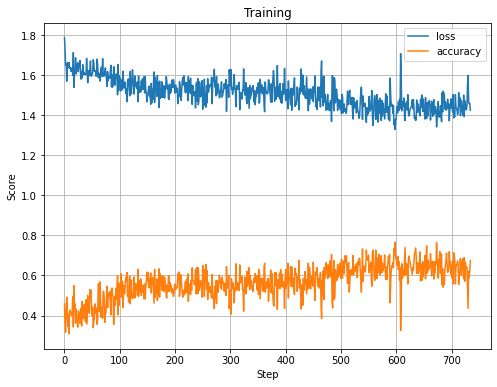

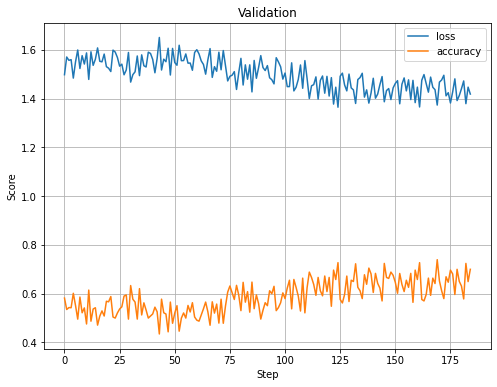

In [258]:
plot_training(train_loss, train_metric, val_loss, val_metric)


Все достаточно печально, попробуем другие параметры

# Эксперименты
Попробуем менять наличие начального дропаута и разные размеры фильтров

Params: 
	 drop_first=0, 
	 filters=[2]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1470.26it/s]


	Train loss: 1.5915134739713603	 Train accuracy: 0.47526460886001587

Validating...
	Train loss: 1.5379218088613975	 Train accuracy: 0.5426064729690552

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1453.85it/s]


	Train loss: 1.5603291534242176	 Train accuracy: 0.5129342675209045

Validating...
	Train loss: 1.5331349695051038	 Train accuracy: 0.5506481528282166

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1481.87it/s]


	Train loss: 1.547986181955489	 Train accuracy: 0.527340829372406

Validating...
	Train loss: 1.5317288884171494	 Train accuracy: 0.5518936514854431

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1447.42it/s]


	Train loss: 1.5408584830306826	 Train accuracy: 0.535720705986023

Validating...
	Train loss: 1.5329725822886906	 Train accuracy: 0.5504615902900696

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1468.27it/s]


	Train loss: 1.5314266370267284	 Train accuracy: 0.5462871193885803

Validating...
	Train loss: 1.518450318156062	 Train accuracy: 0.5660215616226196


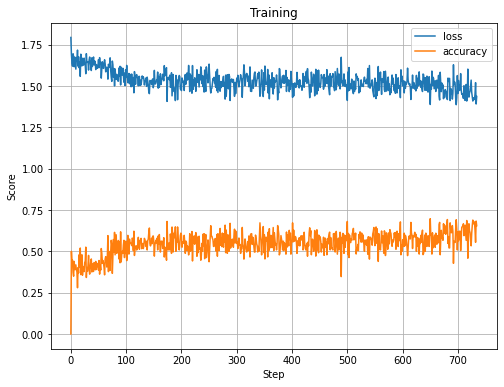

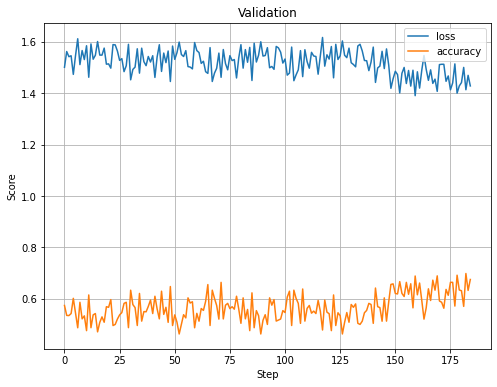

Params: 
	 drop_first=1, 
	 filters=[2]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1461.60it/s]


	Train loss: 1.5945234258158678	 Train accuracy: 0.47849538922309875

Validating...
	Train loss: 1.5310712440593823	 Train accuracy: 0.5554793477058411

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1463.83it/s]


	Train loss: 1.5639665232223718	 Train accuracy: 0.5120397806167603

Validating...
	Train loss: 1.5329818902788936	 Train accuracy: 0.5523039698600769

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1447.17it/s]


	Train loss: 1.5509815667491922	 Train accuracy: 0.5261241793632507

Validating...
	Train loss: 1.5323488766008668	 Train accuracy: 0.5522361397743225

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1464.34it/s]


	Train loss: 1.5437486873192041	 Train accuracy: 0.5337486863136292

Validating...
	Train loss: 1.5306731220838186	 Train accuracy: 0.5532903671264648

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1460.49it/s]


	Train loss: 1.5396824410172547	 Train accuracy: 0.5377935767173767

Validating...
	Train loss: 1.5312087239445866	 Train accuracy: 0.5525227189064026


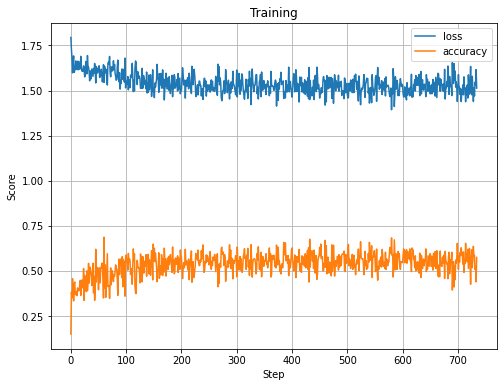

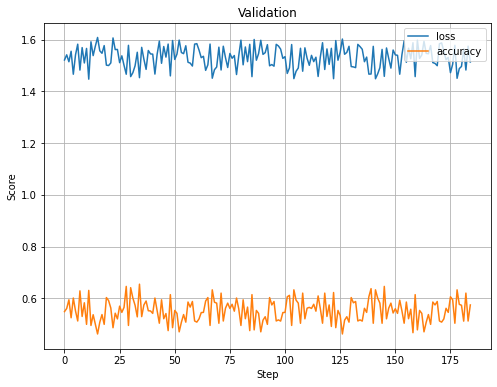

Params: 
	 drop_first=0, 
	 filters=[3]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:13<00:00, 1415.19it/s]


	Train loss: 1.5974843615577334	 Train accuracy: 0.475311279296875

Validating...
	Train loss: 1.5375842951439522	 Train accuracy: 0.5475317239761353

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:13<00:00, 1419.24it/s]


	Train loss: 1.5656937510788846	 Train accuracy: 0.5110910534858704

Validating...
	Train loss: 1.5319831999572548	 Train accuracy: 0.5515754818916321

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:13<00:00, 1398.40it/s]


	Train loss: 1.5509960908197762	 Train accuracy: 0.5264002680778503

Validating...
	Train loss: 1.5274547886204075	 Train accuracy: 0.5560712218284607

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:13<00:00, 1405.56it/s]


	Train loss: 1.5386486112260493	 Train accuracy: 0.5399447083473206

Validating...
	Train loss: 1.5166270579840686	 Train accuracy: 0.5685296654701233

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:13<00:00, 1398.03it/s]


	Train loss: 1.5201727048069442	 Train accuracy: 0.5595415234565735

Validating...
	Train loss: 1.511791745392052	 Train accuracy: 0.5726306438446045


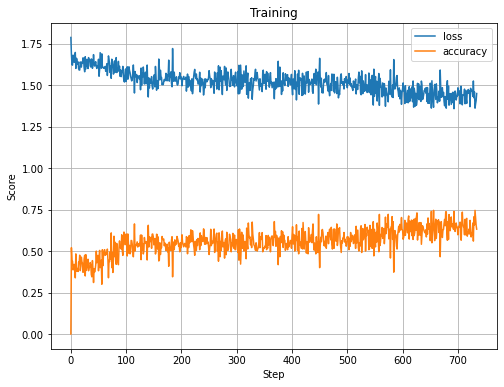

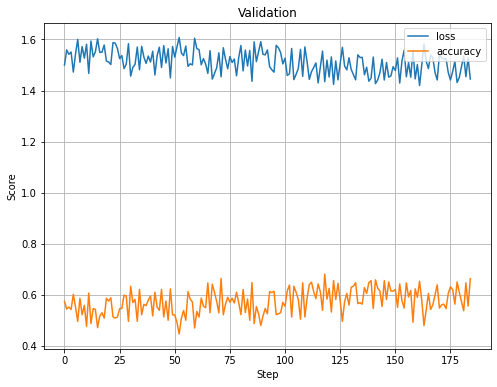

Params: 
	 drop_first=1, 
	 filters=[3]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:13<00:00, 1410.88it/s]


	Train loss: 1.560017820118236	 Train accuracy: 0.5184822082519531

Validating...
	Train loss: 1.5471607672201622	 Train accuracy: 0.5333834886550903

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:14<00:00, 1339.20it/s]


	Train loss: 1.5436774098954233	 Train accuracy: 0.5351333022117615

Validating...
	Train loss: 1.5447964120555568	 Train accuracy: 0.5337883234024048

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:13<00:00, 1391.21it/s]


	Train loss: 1.535619933859291	 Train accuracy: 0.5433620810508728

Validating...
	Train loss: 1.5334156279091362	 Train accuracy: 0.547682523727417

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:13<00:00, 1382.61it/s]


	Train loss: 1.520850342755415	 Train accuracy: 0.5594066381454468

Validating...
	Train loss: 1.5120950002928037	 Train accuracy: 0.570866048336029

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:13<00:00, 1390.11it/s]


	Train loss: 1.5053774306563292	 Train accuracy: 0.575459897518158

Validating...
	Train loss: 1.4988725449587847	 Train accuracy: 0.5846385359764099


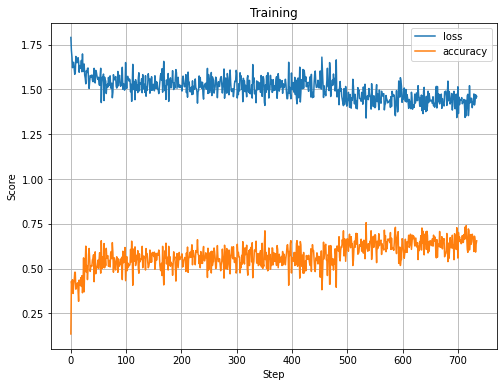

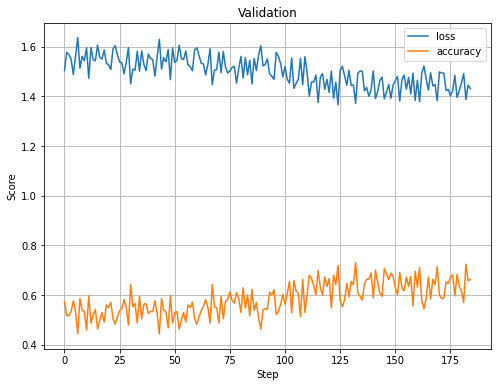

Params: 
	 drop_first=0, 
	 filters=[4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:14<00:00, 1328.96it/s]


	Train loss: 1.603496038183874	 Train accuracy: 0.47804611921310425

Validating...
	Train loss: 1.5453093502972577	 Train accuracy: 0.5296338796615601

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:13<00:00, 1379.57it/s]


	Train loss: 1.5574497941399918	 Train accuracy: 0.5240236520767212

Validating...
	Train loss: 1.576901437462987	 Train accuracy: 0.49756529927253723

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:13<00:00, 1387.66it/s]


	Train loss: 1.5204905409391234	 Train accuracy: 0.5614942312240601

Validating...
	Train loss: 1.533144992751044	 Train accuracy: 0.5458083748817444

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:13<00:00, 1370.47it/s]


	Train loss: 1.4987557427007325	 Train accuracy: 0.5838273763656616

Validating...
	Train loss: 1.51024664656536	 Train accuracy: 0.5702965259552002

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:13<00:00, 1367.15it/s]


	Train loss: 1.4853873364779413	 Train accuracy: 0.5972455143928528

Validating...
	Train loss: 1.5102455731984732	 Train accuracy: 0.5687223076820374


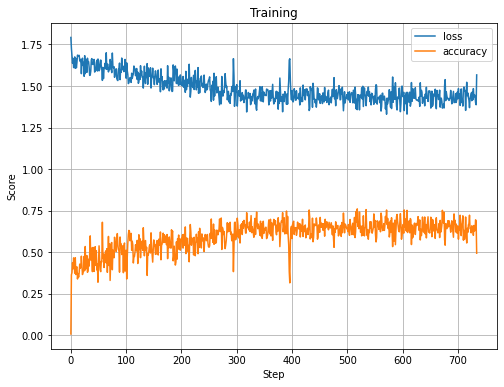

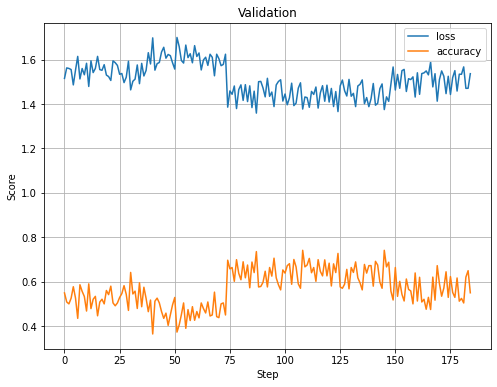

Params: 
	 drop_first=1, 
	 filters=[4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:14<00:00, 1337.54it/s]


	Train loss: 1.6091763681294966	 Train accuracy: 0.4504897892475128

Validating...
	Train loss: 1.4709779926248499	 Train accuracy: 0.6357541084289551

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:13<00:00, 1357.13it/s]


	Train loss: 1.5251005409526177	 Train accuracy: 0.5482739806175232

Validating...
	Train loss: 1.506270039725948	 Train accuracy: 0.5832902789115906

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:13<00:00, 1350.79it/s]


	Train loss: 1.4940454216500798	 Train accuracy: 0.5831406712532043

Validating...
	Train loss: 1.4816285436217849	 Train accuracy: 0.6071773767471313

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:13<00:00, 1353.20it/s]


	Train loss: 1.4785326988924117	 Train accuracy: 0.5996465086936951

Validating...
	Train loss: 1.4685302586168856	 Train accuracy: 0.6196596026420593

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:13<00:00, 1347.39it/s]


	Train loss: 1.4680875400296685	 Train accuracy: 0.6109634637832642

Validating...
	Train loss: 1.4607921117060894	 Train accuracy: 0.6264463067054749


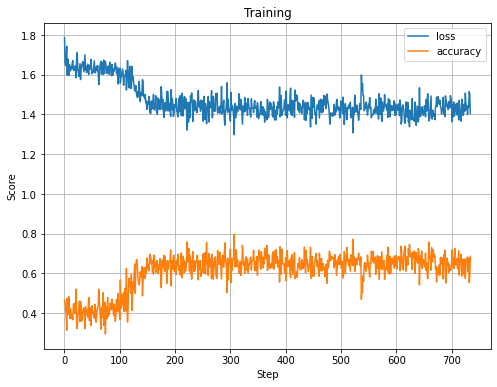

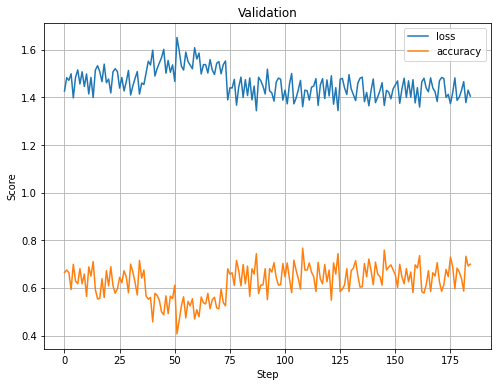

Params: 
	 drop_first=0, 
	 filters=[2, 3]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:21<00:00, 873.85it/s]


	Train loss: 1.5901915613485842	 Train accuracy: 0.4838907718658447

Validating...
	Train loss: 1.5282470664462529	 Train accuracy: 0.5588891506195068

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:21<00:00, 867.77it/s]


	Train loss: 1.5521815990915104	 Train accuracy: 0.5241958498954773

Validating...
	Train loss: 1.5025843414100442	 Train accuracy: 0.5842344164848328

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:21<00:00, 861.86it/s]


	Train loss: 1.5167680459768593	 Train accuracy: 0.5622099041938782

Validating...
	Train loss: 1.48216099782033	 Train accuracy: 0.6045659780502319

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 864.18it/s]


	Train loss: 1.4967862965703822	 Train accuracy: 0.5835381150245667

Validating...
	Train loss: 1.4749761014371305	 Train accuracy: 0.611971914768219

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 867.68it/s]


	Train loss: 1.4836036570218145	 Train accuracy: 0.5973734259605408

Validating...
	Train loss: 1.466220701707376	 Train accuracy: 0.620737612247467


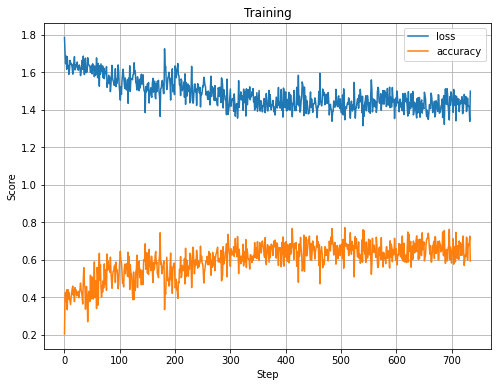

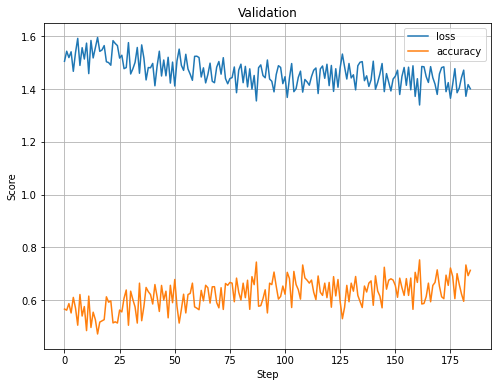

Params: 
	 drop_first=1, 
	 filters=[2, 3]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:21<00:00, 859.94it/s]


	Train loss: 1.6095586763758238	 Train accuracy: 0.45515307784080505

Validating...
	Train loss: 1.5770814032168001	 Train accuracy: 0.5389896035194397

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:21<00:00, 861.76it/s]


	Train loss: 1.5720863666664175	 Train accuracy: 0.5001740455627441

Validating...
	Train loss: 1.5628762986208942	 Train accuracy: 0.5355639457702637

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:21<00:00, 863.46it/s]


	Train loss: 1.5593785990933442	 Train accuracy: 0.5145716667175293

Validating...
	Train loss: 1.552517506453368	 Train accuracy: 0.5413944721221924

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 866.53it/s]


	Train loss: 1.546699129805273	 Train accuracy: 0.5285512208938599

Validating...
	Train loss: 1.5305532055932123	 Train accuracy: 0.56174635887146

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 860.85it/s]


	Train loss: 1.5342044397276275	 Train accuracy: 0.5418508648872375

Validating...
	Train loss: 1.5150092434238742	 Train accuracy: 0.5765689611434937


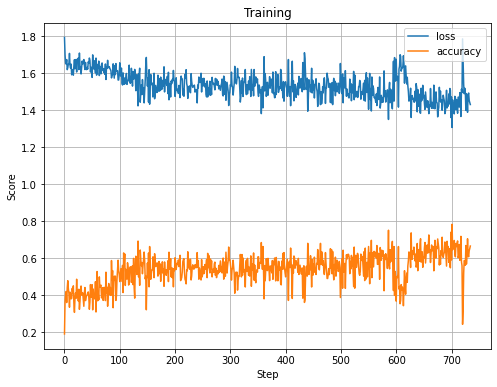

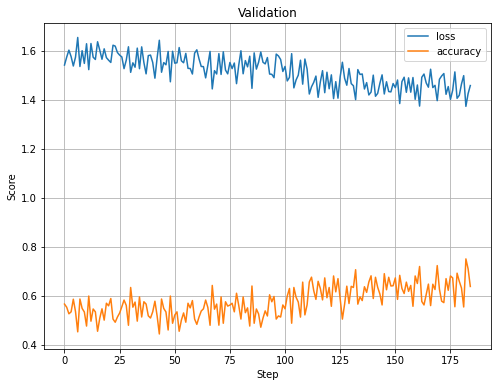

Params: 
	 drop_first=0, 
	 filters=[3, 4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:22<00:00, 841.60it/s]


	Train loss: 1.6020590650792024	 Train accuracy: 0.46862637996673584

Validating...
	Train loss: 1.5400675792951841	 Train accuracy: 0.5394315719604492

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:22<00:00, 834.14it/s]


	Train loss: 1.5661896479373076	 Train accuracy: 0.5085292458534241

Validating...
	Train loss: 1.5330679642187584	 Train accuracy: 0.5502918362617493

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:22<00:00, 844.93it/s]


	Train loss: 1.5511182489849271	 Train accuracy: 0.5250675082206726

Validating...
	Train loss: 1.5258508770315498	 Train accuracy: 0.557669460773468

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:22<00:00, 836.08it/s]


	Train loss: 1.5320400571336552	 Train accuracy: 0.5461283326148987

Validating...
	Train loss: 1.5097744344054043	 Train accuracy: 0.574144184589386

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:22<00:00, 830.12it/s]


	Train loss: 1.51582261429352	 Train accuracy: 0.5631651878356934

Validating...
	Train loss: 1.4974931968225016	 Train accuracy: 0.5867190957069397


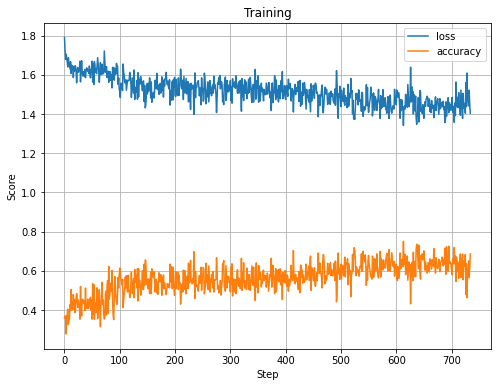

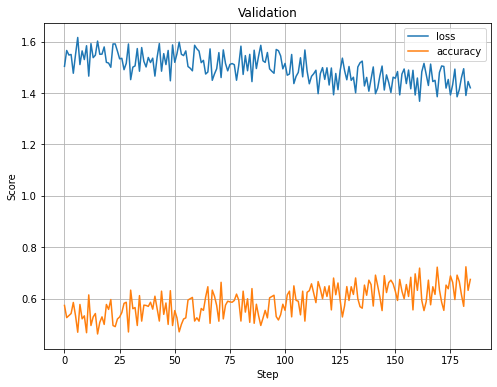

Params: 
	 drop_first=1, 
	 filters=[3, 4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:22<00:00, 828.92it/s]


	Train loss: 1.6047560755087404	 Train accuracy: 0.46832332015037537

Validating...
	Train loss: 1.5429915673023946	 Train accuracy: 0.5346478819847107

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:22<00:00, 827.88it/s]


	Train loss: 1.5699566014769937	 Train accuracy: 0.5068367123603821

Validating...
	Train loss: 1.5364077397294946	 Train accuracy: 0.5432776808738708

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:22<00:00, 833.58it/s]


	Train loss: 1.5587932982412325	 Train accuracy: 0.5185601115226746

Validating...
	Train loss: 1.534452798130276	 Train accuracy: 0.5463759899139404

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:22<00:00, 827.55it/s]


	Train loss: 1.5495368759242856	 Train accuracy: 0.5283347368240356

Validating...
	Train loss: 1.53427893406636	 Train accuracy: 0.5456622242927551

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:22<00:00, 828.37it/s]


	Train loss: 1.5435500482312676	 Train accuracy: 0.5346488952636719

Validating...
	Train loss: 1.5338626900234738	 Train accuracy: 0.547062873840332


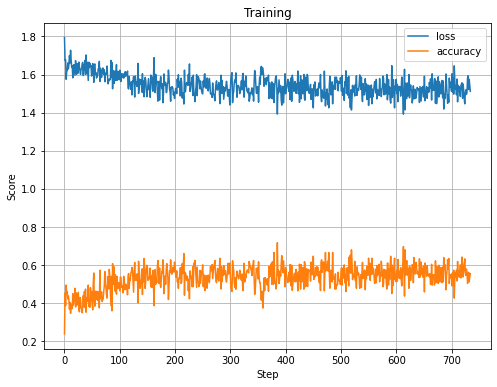

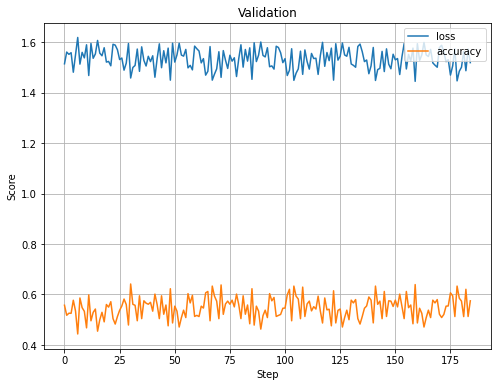

Params: 
	 drop_first=0, 
	 filters=[2, 4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:22<00:00, 847.40it/s]


	Train loss: 1.5900769695943715	 Train accuracy: 0.49285104870796204

Validating...
	Train loss: 1.5657860201758307	 Train accuracy: 0.4929562509059906

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:22<00:00, 848.68it/s]


	Train loss: 1.5263866295619888	 Train accuracy: 0.5581341981887817

Validating...
	Train loss: 1.5060653203242533	 Train accuracy: 0.5675989389419556

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:22<00:00, 846.58it/s]


	Train loss: 1.4945357591927457	 Train accuracy: 0.5902314782142639

Validating...
	Train loss: 1.4844505572104238	 Train accuracy: 0.5930027961730957

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:22<00:00, 845.84it/s]


	Train loss: 1.478705221090187	 Train accuracy: 0.6057364344596863

Validating...
	Train loss: 1.4719144194512754	 Train accuracy: 0.607564389705658

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:22<00:00, 850.25it/s]


	Train loss: 1.4686572117059409	 Train accuracy: 0.6156410574913025

Validating...
	Train loss: 1.4664749654563698	 Train accuracy: 0.6139388680458069


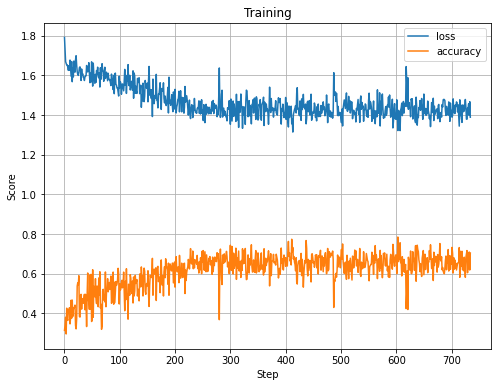

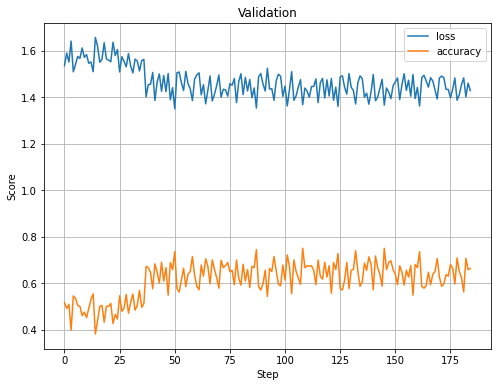

Params: 
	 drop_first=1, 
	 filters=[2, 4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:22<00:00, 847.68it/s]


	Train loss: 1.5565573885327293	 Train accuracy: 0.5176239609718323

Validating...
	Train loss: 1.4565980015574276	 Train accuracy: 0.6312664151191711

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:22<00:00, 845.11it/s]


	Train loss: 1.4984601577933954	 Train accuracy: 0.5808115601539612

Validating...
	Train loss: 1.4490097293982636	 Train accuracy: 0.6396687030792236

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:22<00:00, 840.02it/s]


	Train loss: 1.478885554942955	 Train accuracy: 0.6017403602600098

Validating...
	Train loss: 1.4457035752030107	 Train accuracy: 0.6420155167579651

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:22<00:00, 842.42it/s]


	Train loss: 1.4669217773440744	 Train accuracy: 0.6140520572662354

Validating...
	Train loss: 1.4420781288598035	 Train accuracy: 0.6451708078384399

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:22<00:00, 846.29it/s]


	Train loss: 1.4592673875847642	 Train accuracy: 0.6220329999923706

Validating...
	Train loss: 1.4399852340285841	 Train accuracy: 0.647134006023407


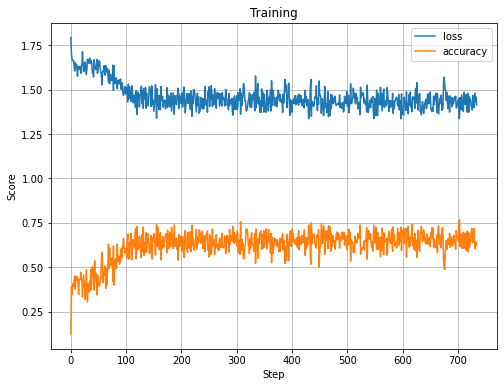

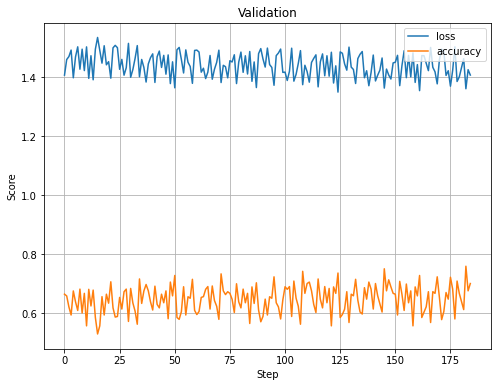

Params: 
	 drop_first=0, 
	 filters=[2, 3, 4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:30<00:00, 618.42it/s]


	Train loss: 1.5813990069084427	 Train accuracy: 0.49919843673706055

Validating...
	Train loss: 1.4650576404623084	 Train accuracy: 0.6324628591537476

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:30<00:00, 617.53it/s]


	Train loss: 1.5097884766909542	 Train accuracy: 0.5741108059883118

Validating...
	Train loss: 1.4529895879126884	 Train accuracy: 0.6392994523048401

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:30<00:00, 614.59it/s]


	Train loss: 1.483235065899198	 Train accuracy: 0.6006800532341003

Validating...
	Train loss: 1.447682962761269	 Train accuracy: 0.6435460448265076

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:30<00:00, 617.22it/s]


	Train loss: 1.4685645056825105	 Train accuracy: 0.6155156493186951

Validating...
	Train loss: 1.4431136218277183	 Train accuracy: 0.6467703580856323

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:30<00:00, 616.37it/s]


	Train loss: 1.4591856072549105	 Train accuracy: 0.6248597502708435

Validating...
	Train loss: 1.4397668007257822	 Train accuracy: 0.6497082114219666


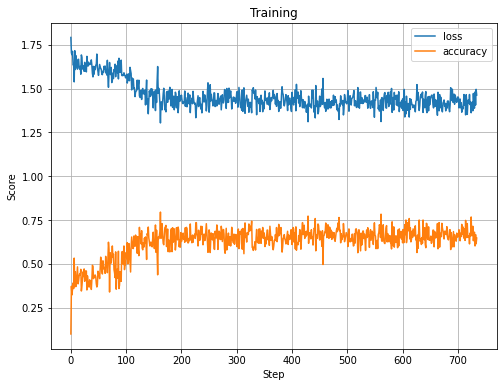

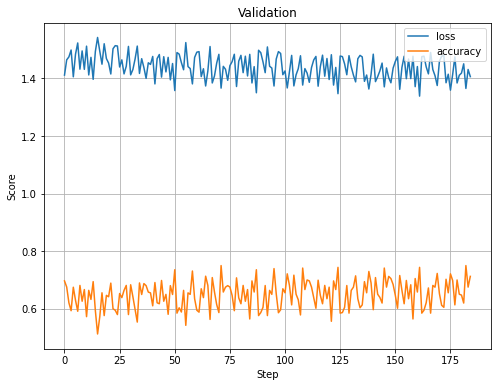

Params: 
	 drop_first=1, 
	 filters=[2, 3, 4]

Training...


Epoch 1: 100%|██████████| 18782/18782 [00:30<00:00, 615.04it/s]


	Train loss: 1.5742050863447643	 Train accuracy: 0.4982658326625824

Validating...
	Train loss: 1.5278259644637238	 Train accuracy: 0.5614550709724426

Training...


Epoch 2: 100%|██████████| 18782/18782 [00:30<00:00, 614.97it/s]


	Train loss: 1.528946465780946	 Train accuracy: 0.5479705333709717

Validating...
	Train loss: 1.4914458957878318	 Train accuracy: 0.597093939781189

Training...


Epoch 3: 100%|██████████| 18782/18782 [00:30<00:00, 612.97it/s]


	Train loss: 1.5017024962539847	 Train accuracy: 0.5773438811302185

Validating...
	Train loss: 1.4781029847291138	 Train accuracy: 0.6098073720932007

Training...


Epoch 4: 100%|██████████| 18782/18782 [00:30<00:00, 616.07it/s]


	Train loss: 1.4859258021627153	 Train accuracy: 0.594449520111084

Validating...
	Train loss: 1.468186234300201	 Train accuracy: 0.619251549243927

Training...


Epoch 5: 100%|██████████| 18782/18782 [00:30<00:00, 614.99it/s]


	Train loss: 1.4758927838331988	 Train accuracy: 0.6046318411827087

Validating...
	Train loss: 1.4619853142145518	 Train accuracy: 0.6248196363449097


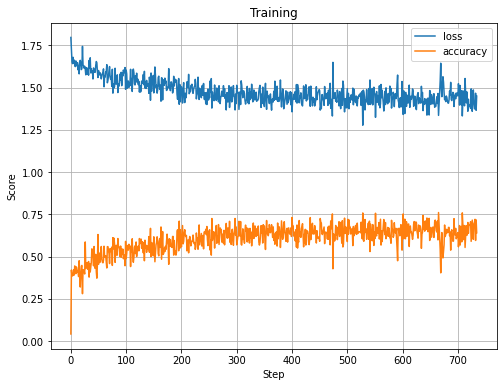

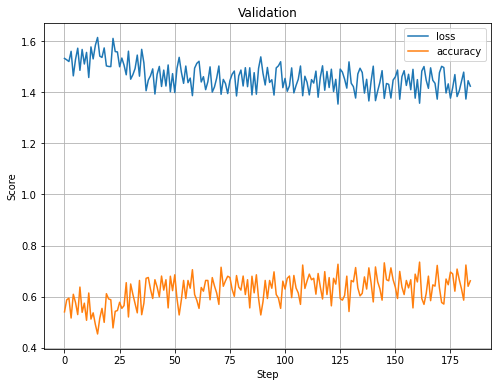

In [265]:
results = []
# в статье такие
filter_sizes = [[2], [3], [4], [2, 3], [3, 4], [2, 4], [2, 3, 4]]

for size in filter_sizes:
    for init_drop in [0, 1]:
        
        print('Params: ')
        print(f'\t drop_first={init_drop}, \n\t filters={size}')
        
        
        model = C_LSTM(weights=weights, vocab_size=len(word2id), 
                       max_len=MAX_LEN, filter_sizes=size, init_drop=init_drop)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)

        train_loss, val_loss, train_metric, val_metric = run_training(
            model, train_iterator, val_iterator, optimizer, criterion, accuracy, EPOCHS)

        results.append({
            'init_drop': init_drop,
            'filter_size': size,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metric': train_metric,
            'val_metric': val_metric})
        plot_training(train_loss, train_metric, val_loss, val_metric)

In [268]:
res_df = pd.DataFrame(results)

In [270]:
res_df

,init_drop,filter_size,train_loss,val_loss,train_metric,val_metric
0,0,[2],"[1.7938693761825562, 1.6929900646209717, 1.636...","[1.5012997388839722, 1.5626360177993774, 1.542...","[0.0, 0.5, 0.4262295, 0.446281, 0.37068966, 0....","[0.5737705, 0.5350877, 0.5344828, 0.5423729, 0..."
1,1,[2],"[1.7943205833435059, 1.7293535470962524, 1.680...","[1.521267056465149, 1.5411884784698486, 1.5144...","[0.15, 0.38135594, 0.35, 0.456, 0.40495867, 0....","[0.5491803, 0.5614035, 0.5948276, 0.52542377, ..."
2,0,[3],"[1.7886606454849243, 1.687406301498413, 1.6236...","[1.4997279644012451, 1.5591496229171753, 1.541...","[0.0, 0.5206612, 0.44262296, 0.4390244, 0.3865...","[0.5737705, 0.54385966, 0.55172414, 0.5423729,..."
3,1,[3],"[1.7903666496276855, 1.7165908813476562, 1.681...","[1.503495454788208, 1.5776028633117676, 1.5679...","[0.13445379, 0.42857143, 0.40350878, 0.4369748...","[0.5737705, 0.51754385, 0.51724136, 0.5338983,..."
4,0,[4],"[1.7915525436401367, 1.7258334159851074, 1.678...","[1.5157928466796875, 1.5630658864974976, 1.560...","[0.008474576, 0.36440676, 0.37704918, 0.436974...","[0.5491803, 0.50877196, 0.5, 0.52542377, 0.577..."
5,1,[4],"[1.7875770330429077, 1.6639046669006348, 1.646...","[1.4262924194335938, 1.482464075088501, 1.4712...","[0.4642857, 0.45081967, 0.41463414, 0.40350878...","[0.66393447, 0.6754385, 0.6637931, 0.59322035,..."
6,0,"[2, 3]","[1.7865052223205566, 1.7017321586608887, 1.646...","[1.5053246021270752, 1.543460488319397, 1.5193...","[0.20338984, 0.41525424, 0.425, 0.375, 0.43902...","[0.56557375, 0.5614035, 0.5862069, 0.5508475, ..."
7,1,"[2, 3]","[1.7930952310562134, 1.6995891332626343, 1.654...","[1.5414750576019287, 1.573952317237854, 1.6023...","[0.19166666, 0.36585367, 0.40163934, 0.4210526...","[0.5655738, 0.55263156, 0.5258621, 0.5338983, ..."
8,0,"[3, 4]","[1.7913408279418945, 1.7264628410339355, 1.679...","[1.503711223602295, 1.5654058456420898, 1.5477...","[0.35833332, 0.36666667, 0.3697479, 0.27731094...","[0.5737705, 0.5263158, 0.5344827, 0.5423729, 0..."
9,1,"[3, 4]","[1.7944228649139404, 1.6742092370986938, 1.677...","[1.5147086381912231, 1.5611692667007446, 1.552...","[0.23931624, 0.45454547, 0.38842976, 0.4958677...","[0.5573771, 0.51754385, 0.5258621, 0.52542377,..."


In [274]:
max_accuracy = []
min_loss = []
mean_accuracy = []
mean_loss = []
for res in results:
    max_accuracy.append(max(res['val_metric']))
    min_loss.append(min(res['val_loss']))
    mean_accuracy.append(np.mean(res['val_metric']))
    mean_loss.append(np.mean(res['val_loss']))
    
res_df['max_accuracy'] = max_accuracy
res_df['min_loss'] = min_loss
res_df['mean_accuracy'] = mean_accuracy
res_df['mean_loss'] = mean_loss

In [277]:
res_df

,init_drop,filter_size,train_loss,val_loss,train_metric,val_metric,max_accuracy,min_loss,mean_accuracy,mean_loss
0,0,[2],"[1.7938693761825562, 1.6929900646209717, 1.636...","[1.5012997388839722, 1.5626360177993774, 1.542...","[0.0, 0.5, 0.4262295, 0.446281, 0.37068966, 0....","[0.5737705, 0.5350877, 0.5344828, 0.5423729, 0...",0.69827586,1.390771,0.566022,1.518450
1,1,[2],"[1.7943205833435059, 1.7293535470962524, 1.680...","[1.521267056465149, 1.5411884784698486, 1.5144...","[0.15, 0.38135594, 0.35, 0.456, 0.40495867, 0....","[0.5491803, 0.5614035, 0.5948276, 0.52542377, ...",0.65517247,1.447174,0.552523,1.531209
2,0,[3],"[1.7886606454849243, 1.687406301498413, 1.6236...","[1.4997279644012451, 1.5591496229171753, 1.541...","[0.0, 0.5206612, 0.44262296, 0.4390244, 0.3865...","[0.5737705, 0.54385966, 0.55172414, 0.5423729,...",0.68103445,1.419642,0.572631,1.511792
3,1,[3],"[1.7903666496276855, 1.7165908813476562, 1.681...","[1.503495454788208, 1.5776028633117676, 1.5679...","[0.13445379, 0.42857143, 0.40350878, 0.4369748...","[0.5737705, 0.51754385, 0.51724136, 0.5338983,...",0.73109245,1.365736,0.584639,1.498873
4,0,[4],"[1.7915525436401367, 1.7258334159851074, 1.678...","[1.5157928466796875, 1.5630658864974976, 1.560...","[0.008474576, 0.36440676, 0.37704918, 0.436974...","[0.5491803, 0.50877196, 0.5, 0.52542377, 0.577...",0.7413793,1.359436,0.568722,1.510246
5,1,[4],"[1.7875770330429077, 1.6639046669006348, 1.646...","[1.4262924194335938, 1.482464075088501, 1.4712...","[0.4642857, 0.45081967, 0.41463414, 0.40350878...","[0.66393447, 0.6754385, 0.6637931, 0.59322035,...",0.76724136,1.343687,0.626446,1.460792
6,0,"[2, 3]","[1.7865052223205566, 1.7017321586608887, 1.646...","[1.5053246021270752, 1.543460488319397, 1.5193...","[0.20338984, 0.41525424, 0.425, 0.375, 0.43902...","[0.56557375, 0.5614035, 0.5862069, 0.5508475, ...",0.75206614,1.339543,0.620738,1.466221
7,1,"[2, 3]","[1.7930952310562134, 1.6995891332626343, 1.654...","[1.5414750576019287, 1.573952317237854, 1.6023...","[0.19166666, 0.36585367, 0.40163934, 0.4210526...","[0.5655738, 0.55263156, 0.5258621, 0.5338983, ...",0.75,1.372840,0.576569,1.515009
8,0,"[3, 4]","[1.7913408279418945, 1.7264628410339355, 1.679...","[1.503711223602295, 1.5654058456420898, 1.5477...","[0.35833332, 0.36666667, 0.3697479, 0.27731094...","[0.5737705, 0.5263158, 0.5344827, 0.5423729, 0...",0.7241379,1.367868,0.586719,1.497493
9,1,"[3, 4]","[1.7944228649139404, 1.6742092370986938, 1.677...","[1.5147086381912231, 1.5611692667007446, 1.552...","[0.23931624, 0.45454547, 0.38842976, 0.4958677...","[0.5573771, 0.51754385, 0.5258621, 0.52542377,...",0.64166665,1.445110,0.547063,1.533863


In [311]:
res_df['filter_size'] = res_df['filter_size'].apply(str)
res_df['max_accuracy'] = res_df['max_accuracy'].apply(float)

## Результаты эксперриментов

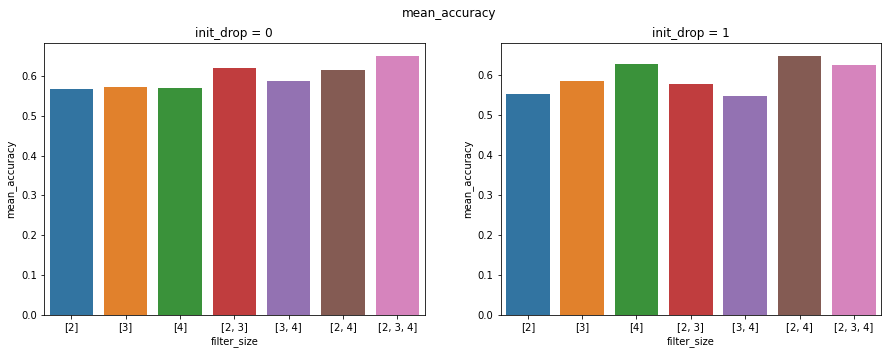

In [326]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(x='filter_size', y='mean_accuracy',
                         data=res_df[res_df['init_drop'] == 0], ax=ax[0])
sns.barplot(x='filter_size', y='mean_accuracy',
                         data=res_df[res_df['init_drop'] == 1], ax=ax[1])
ax[0].set_title('init_drop = 0')
ax[1].set_title('init_drop = 1')
fig.suptitle('mean_accuracy')
fig.show()

Очень сильно отличается от статьи. В нашем случае одиночные фильтры (кроме 4 с дропаутом) показывают худший результат (в статье - лучший)
2,4 и 2,3,4 лучше всего.

Посмотрим средний лосс

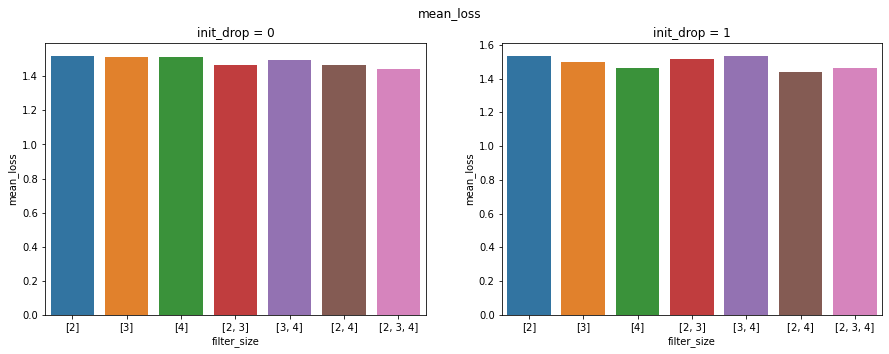

In [328]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(x='filter_size', y='mean_loss',
                         data=res_df[res_df['init_drop'] == 0], ax=ax[0])
sns.barplot(x='filter_size', y='mean_loss',
                         data=res_df[res_df['init_drop'] == 1], ax=ax[1])
ax[0].set_title('init_drop = 0')
ax[1].set_title('init_drop = 1')
fig.suptitle('mean_loss')
fig.show()

Лосс примерно одинаковый, ничего интересного

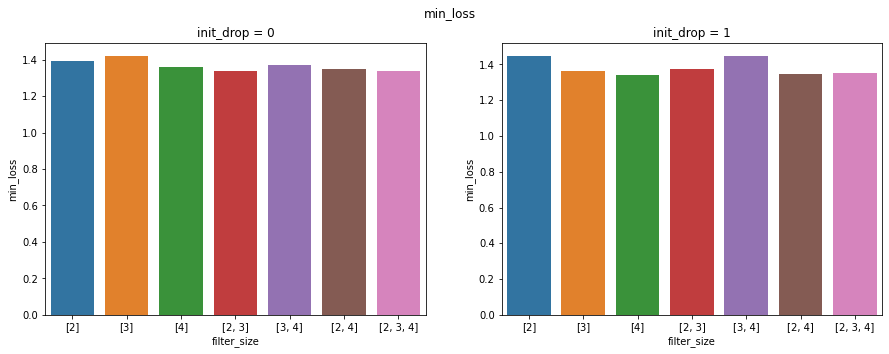

In [327]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(x='filter_size', y='min_loss',
                         data=res_df[res_df['init_drop'] == 0], ax=ax[0])
sns.barplot(x='filter_size', y='min_loss',
                         data=res_df[res_df['init_drop'] == 1], ax=ax[1])
ax[0].set_title('init_drop = 0')
ax[1].set_title('init_drop = 1')
fig.suptitle('min_loss')
fig.show()

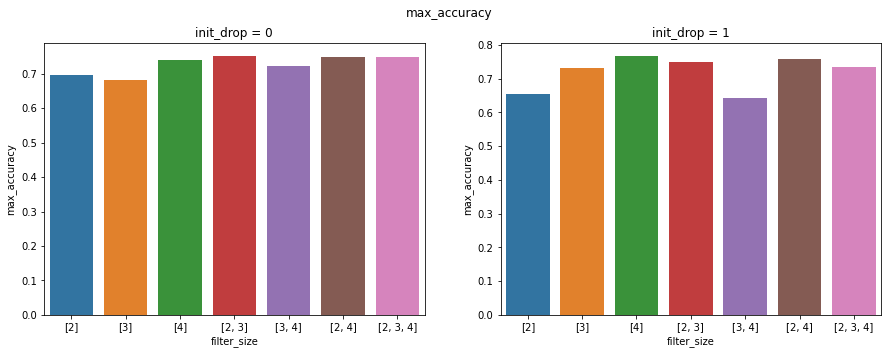

In [330]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(x='filter_size', y='max_accuracy',
                         data=res_df[res_df['init_drop'] == 0], ax=ax[0])
sns.barplot(x='filter_size', y='max_accuracy',
                         data=res_df[res_df['init_drop'] == 1], ax=ax[1])
ax[0].set_title('init_drop = 0')
ax[1].set_title('init_drop = 1')
fig.suptitle('max_accuracy')
fig.show()

Посмоттрим как влияет дропаут

<AxesSubplot:xlabel='filter_size', ylabel='mean_accuracy'>

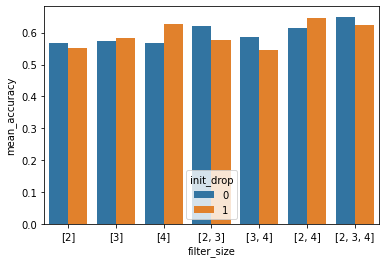

In [333]:
sns.barplot(x="filter_size", y="mean_accuracy", hue="init_drop", data=res_df)

По разному для разных фильтров

Посмотрим лучшие параметры

In [331]:
res_df.iloc[[res_df['mean_accuracy'].idxmax()]]

,init_drop,filter_size,train_loss,val_loss,train_metric,val_metric,max_accuracy,min_loss,mean_accuracy,mean_loss
12,0,"[2, 3, 4]","[1.7921433448791504, 1.7041388750076294, 1.693...","[1.4116523265838623, 1.4646692276000977, 1.474...","[0.099173546, 0.37190083, 0.32231402, 0.356521...","[0.6967213, 0.6754386, 0.62068963, 0.59322035,...",0.75,1.338623,0.649708,1.439767


Вспомним какие у нас размеры классов и сделаем репорт

<AxesSubplot:>

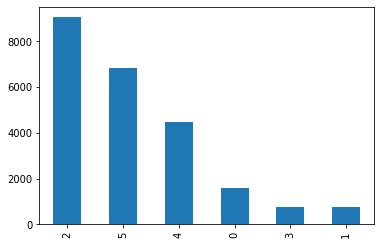

In [340]:
df['category'].value_counts().plot.bar()

In [339]:
preds = []
true = []
for i, (texts, ys) in enumerate(val_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())
    
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       336
           1       0.00      0.00      0.00       157
           2       0.74      0.97      0.84      1764
           3       0.00      0.00      0.00       153
           4       0.33      0.00      0.01       907
           5       0.47      0.80      0.59      1379

    accuracy                           0.60      4696
   macro avg       0.26      0.30      0.24      4696
weighted avg       0.48      0.60      0.49      4696



Собственно понятно, что маленькие классы совсем не классифицируются

## Что делать?

1. Разобраться с диссбалансом классов - единственный вариант что я вижу это менять датасет
2. Понять что делать с MAX_LEN - видимо, тексты длинные, и на коротком кусочке плохо классифицируются
3. Я не пробовал увеличивать memory dim как в статье, но думаю это не поможет
4. На обучении 10+ эпохах у меня происходило переобучение, можно поттом поиграться с learning rate